## Import the necessary libraries

In [10]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [11]:
df = pd.read_csv('DP3 Historical Data.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,04/17/2024,"68,000","68,000","68,300","68,000",8.91K,0.00%
1,04/16/2024,"68,000","68,600","68,600","66,900",10.76K,-0.73%
2,04/15/2024,"68,500","69,300","69,300","68,000",14.22K,-1.15%
3,04/12/2024,"69,300","68,900","69,300","68,900",3.01K,0.58%
4,04/11/2024,"68,900","69,500","69,500","68,200",5.36K,-0.86%
5,04/10/2024,"69,500","69,500","69,500","69,500",2.30K,0.58%
6,04/09/2024,"69,100","70,500","70,500","69,100",2.47K,-1.14%
7,04/08/2024,"69,900","70,000","70,000","68,000",6.30K,-0.14%
8,04/05/2024,"70,000","70,000","70,000","67,500",10.25K,0.00%
9,04/04/2024,"70,000","70,400","70,700","70,000",2.80K,-0.57%


## Data preprocessing

In [12]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [13]:
# Show Dataframe
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,85500,85000,92000,85000,12.70K,0.59%
2019-01-03,86500,85100,87900,85100,6.40K,1.17%
2019-01-04,87900,86700,88000,86600,4.87K,1.62%
2019-01-07,87900,86700,87900,86700,5.10K,0.00%
2019-01-08,91800,88000,92000,88000,19.40K,4.44%
...,...,...,...,...,...,...
2024-04-11,68900,69500,69500,68200,5.36K,-0.86%
2024-04-12,69300,68900,69300,68900,3.01K,0.58%
2024-04-15,68500,69300,69300,68000,14.22K,-1.15%


## Scale Data

In [14]:
# Select 'Close' column
data = df['Price'].values

In [15]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train, validation and test set with a ratio of 7 : 1 : 2

In [16]:
# Define the size of train, validation, test set
train_size = int(len(data_scaled) * 0.8)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

# Split the data into train, test, and validation sets
train_data = data_scaled[:train_size]
val_data = data_scaled[train_size:train_size + val_size]
test_data = data_scaled[train_size + val_size:]

## Create and add data into X, y

In [17]:
# Function to prepare data for LSTM
def add_data(data, sequence_length=60):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [18]:
# Prepare sequences
sequence_length = 60
train_last_windowsize = train_data[-sequence_length:]
val_last_windowsize = val_data[-sequence_length:]

val_data_extended = np.concatenate((train_last_windowsize, val_data), axis=0)
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_val, y_val = add_data(val_data_extended, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

In [19]:
# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Build Model

In [20]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

## Training Model

In [21]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=2)

Epoch 1/50
27/27 - 13s - loss: 0.0262 - val_loss: 0.0644 - 13s/epoch - 487ms/step
Epoch 2/50
27/27 - 3s - loss: 0.0061 - val_loss: 0.0660 - 3s/epoch - 106ms/step
Epoch 3/50
27/27 - 3s - loss: 0.0055 - val_loss: 0.0569 - 3s/epoch - 105ms/step
Epoch 4/50
27/27 - 3s - loss: 0.0050 - val_loss: 0.0514 - 3s/epoch - 106ms/step
Epoch 5/50
27/27 - 5s - loss: 0.0047 - val_loss: 0.0462 - 5s/epoch - 169ms/step
Epoch 6/50
27/27 - 3s - loss: 0.0046 - val_loss: 0.0405 - 3s/epoch - 107ms/step
Epoch 7/50
27/27 - 3s - loss: 0.0049 - val_loss: 0.0459 - 3s/epoch - 107ms/step
Epoch 8/50
27/27 - 3s - loss: 0.0040 - val_loss: 0.0425 - 3s/epoch - 105ms/step
Epoch 9/50
27/27 - 4s - loss: 0.0040 - val_loss: 0.0363 - 4s/epoch - 152ms/step
Epoch 10/50
27/27 - 3s - loss: 0.0035 - val_loss: 0.0391 - 3s/epoch - 113ms/step
Epoch 11/50
27/27 - 3s - loss: 0.0034 - val_loss: 0.0337 - 3s/epoch - 106ms/step
Epoch 12/50
27/27 - 3s - loss: 0.0037 - val_loss: 0.0374 - 3s/epoch - 105ms/step
Epoch 13/50
27/27 - 4s - loss: 0.00

## Predict Close price in test and validation set

In [22]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 54ms/step


## Transform data back to the original

In [23]:
# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

## Calculate the error of the model

In [24]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 766187.104854657
RMSE on Test set: 69279.12522170776
MSLE on Test set: 121.87024560611366


In [25]:
# The error in validation set
val_mape = mean_absolute_percentage_error(y_val, y_pred_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val, y_pred_val)

print(f"MAPE on Validate set: {val_mape}")
print(f"RMSE on Validate set: {val_rmse}")
print(f"MSLE on Validate set: {val_msle}")

MAPE on Validate set: 0.08087552059339725
RMSE on Validate set: 13137.48196378689
MSLE on Validate set: 0.017662888524423305


## Predict Close price for 30 next days

In [26]:
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    next_day_pred = model.predict(last_sequence_days)
    y_next_30_days.append(next_day_pred[0][0])
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)


1/1 [==============================] - 0s 30ms/step


In [27]:
# Show the result of predict 30 next days
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

[70092.38  69869.06  69747.945 69751.93  69867.85  70064.336 70307.63
 70571.12  70838.234 71101.445 71359.21  71612.99  71865.08  72117.305
 72370.734 72625.67  72881.98  73139.34  73397.5   73656.28  73915.66
 74175.74  74436.66  74698.57  74961.664 75226.07  75491.94  75759.36
 76028.45  76299.3  ]


## Model visualization

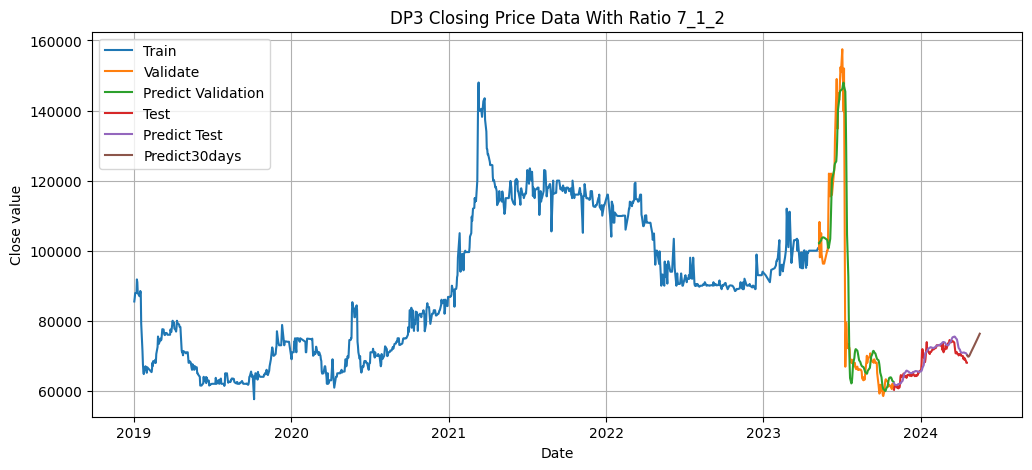

In [28]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(df[:train_size].index, train_data)
plt.plot(df[train_size:train_size + val_size].index, val_data)
plt.plot(df[train_size:train_size + val_size].index, y_pred_val)
plt.plot(df[train_size + val_size:].index, test_data)
plt.plot(df[train_size + val_size:].index, y_pred)
plt.plot(pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), y_next_30_days)
plt.legend(['Train', 'Validate', 'Predict Validation', 'Test', 'Predict Test', 'Predict30days'])
plt.grid()
plt.title("DP3 Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RNN_712_DP3.png')
plt.show()